In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.linalg as la
import math
from numpy import random
import cmath
import time
from sympy import S, symbols, printing

 ### Hamiltonian Initialization

In [2]:
X = np.array([[0, 1],
     [1, 0]])
Z = np.array([[1, 0],
     [0, -1]])
I = np.array([[1, 0],
     [0, 1]])
XX = np.kron(X, X) #tensor products between two Pauli's
XZ = np.kron(X, Z)
ZZ = np.kron(Z, Z)
ZX = np.kron(Z, X)
II = np.kron(I, I)
IX = np.kron(I, X)
XI = np.kron(X, I)
IZ = np.kron(I, Z)

In [3]:
#List of Hamiltonian decomposition terms H_j for H = \sum_j h_j H_j
Hlist = np.array([XX, XZ, ZX, ZZ, IX, IZ])
hj = [1.0, 2.0, 3.0, 4.0, 2.0, 1.0] #list of normalized coefficients

print(Hlist.shape)

hamiltonian_list = []
for i in range(len(hj)):
    hamiltonian_list.append(hj[i] * Hlist[i, :, :]);
hamiltonian_list = np.array(hamiltonian_list)
print(hamiltonian_list.shape)

(6, 4, 4)
(6, 4, 4)


## Notebook using compilers.py

The goal is to compare the functions in compilers.py to the ones witten here in both output and runtimes. The only part of the previous sections that this section will reference is "Hamiltonian Initialization"

### Trotter Simulation

In [4]:
from compilers import TrotterSim

In [5]:
#Example, does not need to be run
#use array hamiltonian_list
sim = TrotterSim([np.array([[0,1], [1,0]])])
print(sim.simulate(np.pi / 2, 4)) #output state should be sigma_X |0> = |1>

[[0.+0.j]
 [0.+1.j]]


In [6]:
sim1 = TrotterSim(hamiltonian_list, 2)
#sim1.initial_state = InitialState

In [7]:
startTime = time.time()

tStart = 0.001
tFinal = 0.1
tSteps = 100
times = np.linspace(tStart, tFinal, tSteps)

trot_compiler_inf = []
for t in times:
    trot_compiler_inf.append(sim1.infidelity(t, 1))

log_trot_compiler_inf = np.log10(trot_compiler_inf)
log_times = np.log10(times)
print(log_trot_compiler_inf.shape)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

(100,)
Execution time in seconds: 0.2811279296875


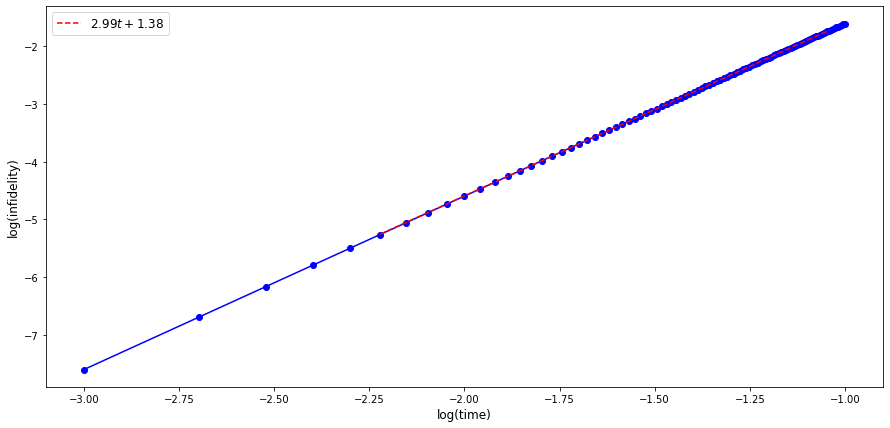

In [8]:
#data = log_trot_compiler_inf[:, 0, 0]
data = log_trot_compiler_inf
plt.figure(figsize = (15, 7))
plt.plot(log_times, data, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

fit_points = 5 #declare the starting point to fit in the data

p = np.polyfit(log_times[fit_points: -10], data[fit_points: -10], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[fit_points], log_times[-10], 50)
y_new = f(t_new)

data = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

### Trotter Sim with Matrix Vector Mult.

In [9]:
from compilers import TrotterSim2 #fourth order is broken
sim2 = TrotterSim2(hamiltonian_list, 2)
print(sim2.simulate(1, 1))

[[-6.67071453e-01+0.33669893j]
 [-6.93889390e-17+0.1979819j ]
 [ 6.03874872e-01-0.13230075j]
 [-1.32997935e-01+0.05094975j]]


In [10]:
startTime = time.time()

tStart = 0.0001
tFinal = 0.01
tSteps = 100
times = np.linspace(tStart, tFinal, tSteps)

trot_compiler_inf = []
for t in times:
    trot_compiler_inf.append(sim2.infidelity(t, 1))

log_trot_compiler_inf = np.log10(trot_compiler_inf)
log_times = np.log10(times)
print(log_trot_compiler_inf.shape)

#data = log_trot_compiler_inf[:, 0, 0]
data = log_trot_compiler_inf
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

(100,)
Execution time in seconds: 0.2655930519104004


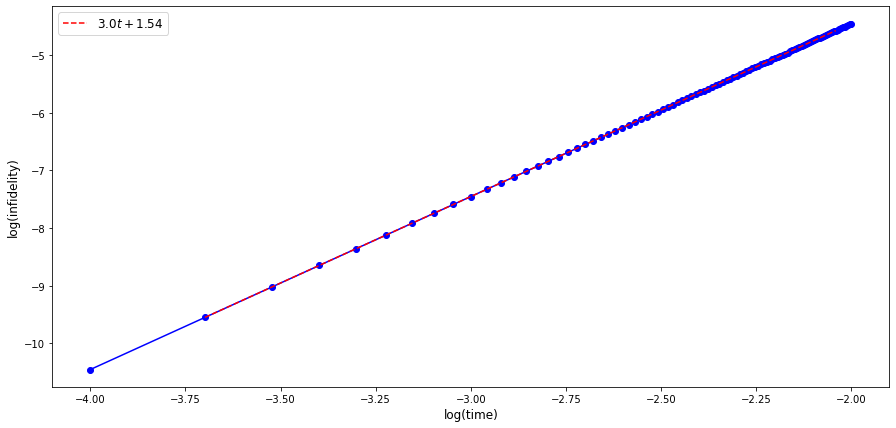

In [11]:
plt.figure(figsize = (15, 7))
plt.plot(log_times, data, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

fit_points = 1 #declare the starting point to fit in the data

p = np.polyfit(log_times[fit_points: -10], data[fit_points: -10], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[fit_points], log_times[-10], 50)
y_new = f(t_new)

data = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()

### QDrift Simulation

In [12]:
from compilers import QDriftSimulator

In [13]:
QDsim = QDriftSimulator(hamiltonian_list)
QDsim.simulate(1, 1000)

array([[0.36340479+0.71730382j],
       [0.14723754+0.50873945j],
       [0.11122723-0.0034909j ],
       [0.02966142-0.24424165j]])

In [14]:
QDsim.sample_channel_inf(1, 1, 40)

array([[0.49824389]])

In [15]:
startTime = time.time()

tStart = 0.0001
tFinal = 0.05
tSteps = 100
times = np.linspace(tStart, tFinal, tSteps) #using logspace seems to break the scaling in the figure?

qd_compiler_inf = []
for t in times:
    qd_compiler_inf.append(QDsim.sample_channel_inf(t, 10, 200))

log_qd_compiler_inf = np.log10(qd_compiler_inf)
log_times = np.log10(times)
print(log_qd_compiler_inf.shape)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

(100, 1, 1)
Execution time in seconds: 47.20829701423645


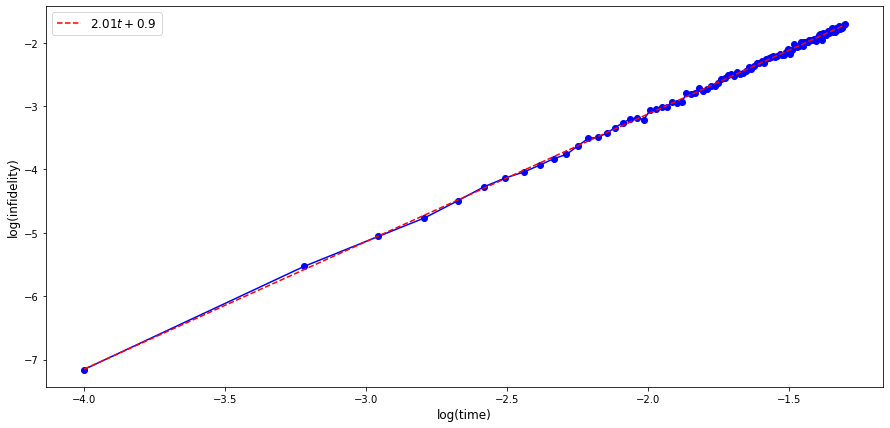

In [16]:
data1 = log_qd_compiler_inf[:, 0, 0]
plt.figure(figsize = (15, 7))
plt.plot(log_times, data1, 'bo-') 
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)

fit_points = 0 #declare the starting point to fit in the data

p = np.polyfit(log_times[fit_points: -1], data1[fit_points: -1], 1)
f = np.poly1d(p)

t_new = np.linspace(log_times[fit_points], log_times[-1], 50)
y_new = f(t_new)

data1 = symbols("t")
poly = sum(S("{:6.2f}".format(v))*data1**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)

plt.plot(t_new, y_new, 'r--', label="${}$".format(eq_latex))
plt.legend(fontsize="large")
plt.show()